# Stock Market Seasonality Detection

This code is focused on detecting seasonality (cyclic patterns) in stock market prices, specifically in the adjusted closing prices of a stock (such as 'AAL').

This project aims to identify and analyze seasonal patterns in stock market prices by applying Fourier Transform and Wavelet Analysis techniques. These methods help detect cyclic behavior in stock prices over time, providing insights into potential periodic trends that can inform trading strategies.

## Load Data

In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

## Inspecting Data

In [2]:
# Load data from ZIP
with zipfile.ZipFile('S&P 500 Stock Data.zip', 'r') as z:
    file_list = z.namelist()  # List all files (e.g., ['A.csv', 'AAL.csv', ...])
    
    # Load first 3 files as samples for inspection
    sample_data = {f: pd.read_csv(z.open(f)) for f in file_list[:3]}

# Inspect a sample file (e.g., A.csv)
print("Sample Data Structure:")
print(sample_data['A.csv'].head())
print("\nMetadata:")
print(sample_data['A.csv'].info())
print("\nMissing Values:")
print(sample_data['A.csv'].isnull().sum())
print("\nMissing Values:")
print(sample_data['A.csv'].describe())

Sample Data Structure:
  Ticker        Date       Open       High        Low      Close  Adj Close  \
0      A  1999-11-18  32.546494  35.765381  28.612303  31.473534  26.794758   
1      A  1999-11-19  30.713518  30.758226  28.478184  28.880545  24.587236   
2      A  1999-11-22  29.551144  31.473534  28.657009  31.473534  26.794758   
3      A  1999-11-23  30.400572  31.205294  28.612303  28.612303  24.358873   
4      A  1999-11-24  28.701717  29.998213  28.612303  29.372318  25.005903   

     Volume  
0  62546380  
1  15234146  
2   6577870  
3   5975611  
4   4843231  

Metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5964 entries, 0 to 5963
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     5964 non-null   object 
 1   Date       5964 non-null   object 
 2   Open       5964 non-null   float64
 3   High       5964 non-null   float64
 4   Low        5964 non-null   float64
 5   Close      5964 

## Visualizing Stock Data

The adjusted close prices for the first stock (AAPL in this case) are plotted over time to visualize the historical trend.

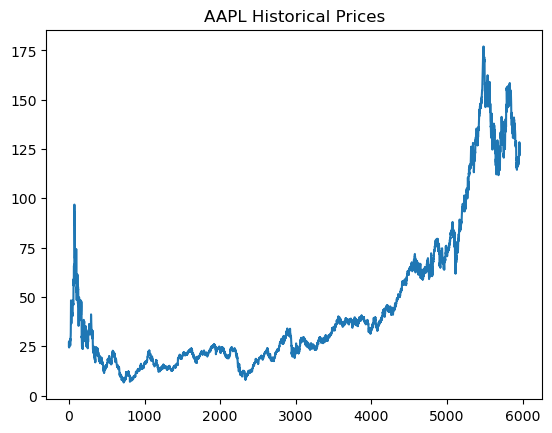

In [3]:
# Visualize a sample stock
sample_data['A.csv']['Adj Close'].plot(title='AAPL Historical Prices')
plt.show()

## Data Cleaning

This includes:

- Date Validation: Ensures the Date column is in datetime format, removing any invalid dates.
- Duplicate Handling: Removes rows with duplicate dates for the same ticker, keeping the most recent entry.
- Price Validation: Ensures price columns (Open, High, Low, Close, Adjusted Close) are numeric and checks for price consistency (e.g., High should not be lower than Low).
- Negative and Zero Prices: Removes rows where any of the price columns contain zero or negative values.
- Volume Validation: Ensures that the Volume column is numeric and non-negative.
- Date Sorting: Ensures the data is sorted chronologically.
- Daily Return Calculation: Adds a Daily_Return column that calculates the daily percentage change in adjusted close prices.

In [4]:
def clean_stock_data(df):
    """Enhanced cleaning for S&P 500 stock data"""
    
    # Convert and validate dates
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[df['Date'].notna()]  # Remove rows with invalid dates
    
    # Handle duplicates (same ticker + date)
    df = df.drop_duplicates(subset=['Ticker', 'Date'], keep='last')
    
    # Validate price columns (OHLC)
    price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    df[price_cols] = df[price_cols].apply(pd.to_numeric, errors='coerce')
    
    # Price consistency checks
    df = df[
        (df['High'] >= df[['Open', 'Low', 'Close']].max(axis=1)) &
        (df['Low'] <= df[['Open', 'High', 'Close']].min(axis=1))
    ]
    
    # Handle zero/negative prices
    df = df[(df[price_cols] > 0).all(axis=1)]
    
    # Volume validation
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
    df = df[df['Volume'] >= 0]
    
    # Sort by date
    df = df.sort_values('Date')
    
    # Calculate returns for later analysis
    df['Daily_Return'] = df.groupby('Ticker')['Adj Close'].pct_change()
    
    return df

# Loading and Cleaning All Data

cleaned_data = {}
with zipfile.ZipFile('S&P 500 Stock Data.zip', 'r') as z:
    for file in z.namelist():
        ticker = file.split('.')[0]
        df = pd.read_csv(z.open(file))
        cleaned_data[ticker] = clean_stock_data(df)

# Validate cleaning
print(f"Cleaned {len(cleaned_data)} stocks")
aapl_stats = cleaned_data['A'].describe()
print(aapl_stats[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

Cleaned 503 stocks
              Open         High          Low        Close    Adj Close  \
count  5964.000000  5964.000000  5964.000000  5964.000000  5964.000000   
mean     47.395558    47.994878    46.788997    47.404786    44.782612   
min       7.653791     7.961373     7.510730     7.761087     6.607346   
25%      22.314020    22.644850    21.988556    22.301501    19.657610   
50%      31.491416    31.918813    31.030043    31.473534    28.291619   
75%      63.954999    64.969999    63.098973    64.112501    60.977356   
max     179.279999   179.570007   177.169998   179.279999   177.025650   
std      38.061525    38.440381    37.637164    38.044148    38.369622   

             Volume  
count  5.964000e+03  
mean   3.408797e+06  
min    2.719000e+05  
25%    1.900525e+06  
50%    2.904974e+06  
75%    4.245481e+06  
max    6.254638e+07  
std    2.421346e+06  


## Seasonality Detection Visualization

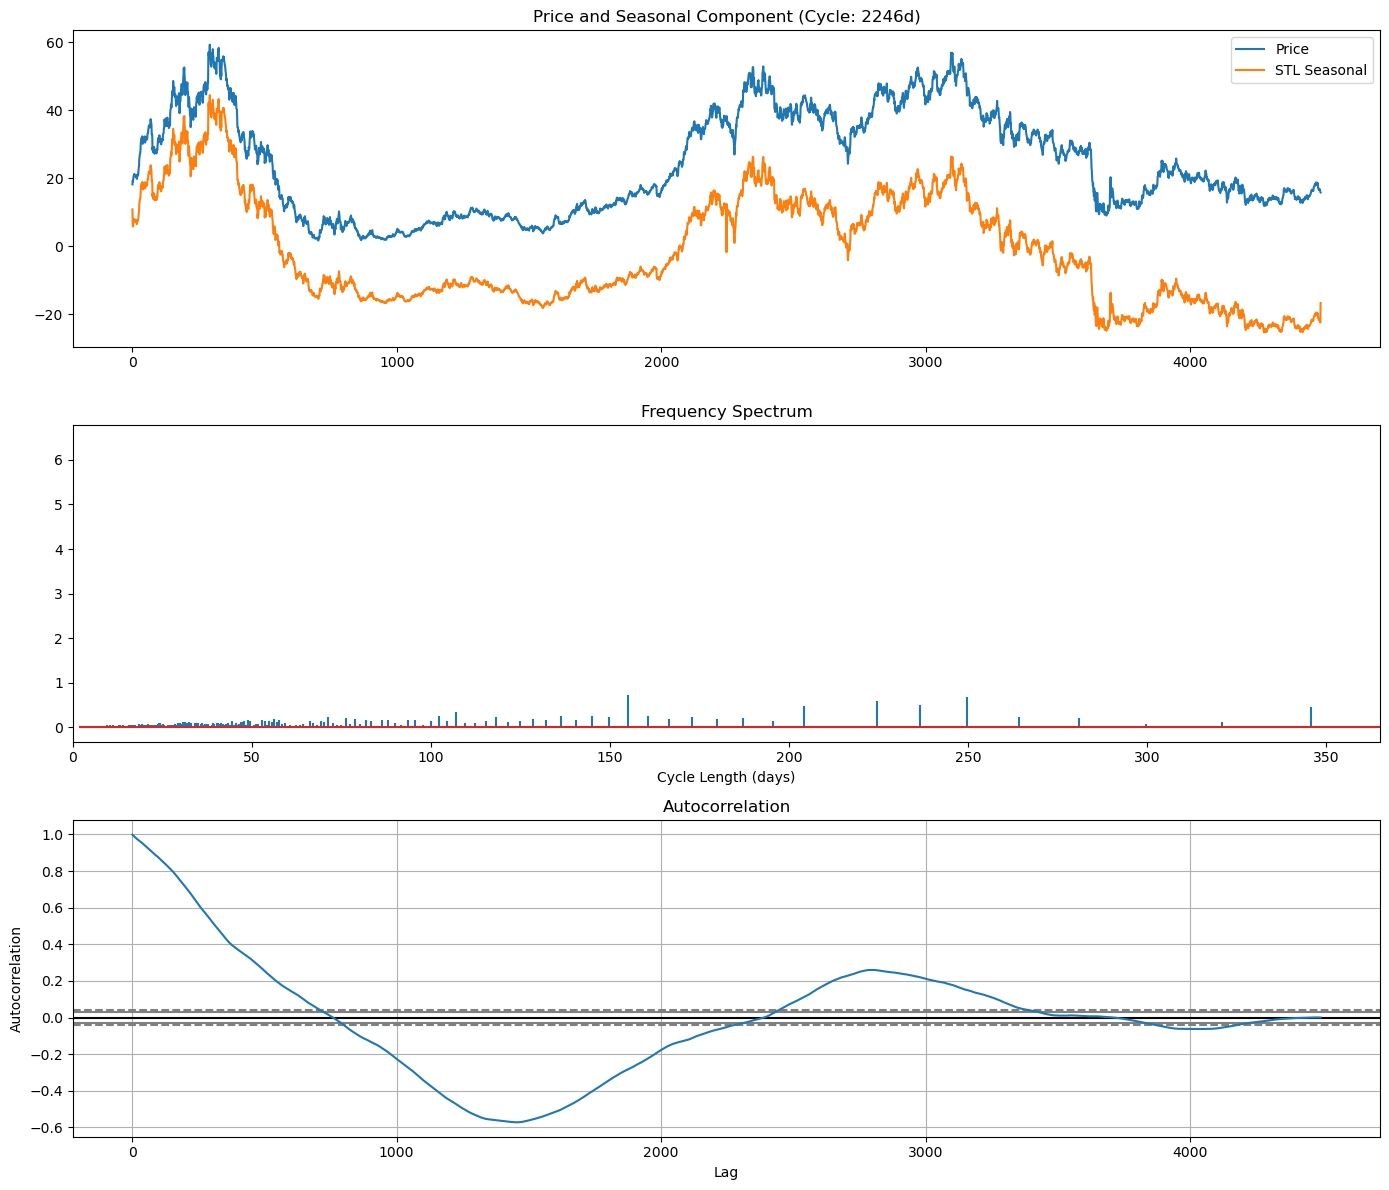


Seasonality Analysis:
- Dominant Cycle: 2246 days
- Strength: 36.7%
- Significant: No



In [5]:
def detect_seasonality(prices, min_cycle=5, max_cycle=365, visualize=True):
    """
    Advanced seasonality detection with validation
    
    Parameters:
    - prices: Pandas Series of prices
    - min_cycle/max_cycle: Valid cycle range (days)
    - visualize: Generate analysis plots
    
    Returns:
    - Dictionary containing:
        - 'dominant_cycle': Detected cycle length (days)
        - 'strength': Signal strength (0-1 scale)
        - 'is_significant': True if cycle passes validation
    """
    # 1. Preprocess
    y = prices.interpolate().values
    n = len(y)
    days = np.arange(n)
    
    # 2. Normalized FFT
    fft_vals = np.abs(fft(y - y.mean())) / n  # Remove DC and normalize
    freqs = fftfreq(n)[1:n//2]  # Positive frequencies only
    
    # 3. Find dominant frequency
    dominant_idx = np.argmax(fft_vals[1:n//2]) + 1
    cycle_days = int(1 / freqs[dominant_idx])
    
    # 4. Validate cycle length
    valid_cycle = min_cycle <= cycle_days <= max_cycle
    
    # 5. Strength calculation (0-1 scale)
    total_energy = np.sum(fft_vals[1:n//2]**2)
    cycle_strength = (fft_vals[dominant_idx]**2) / total_energy
    
    # 6. STL decomposition cross-check
    stl = STL(prices, period=cycle_days).fit()
    seasonal_component = stl.seasonal
    
    if visualize:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
        
        # Price and seasonal component
        ax1.plot(prices, label='Price')
        ax1.plot(seasonal_component, label='STL Seasonal')
        ax1.set_title(f'Price and Seasonal Component (Cycle: {cycle_days}d)')
        ax1.legend()
        
        # FFT spectrum
        ax2.stem(1/freqs, fft_vals[1:n//2], markerfmt=' ')
        ax2.set_xlim(0, max_cycle)
        ax2.axvline(cycle_days, color='r', linestyle='--')
        ax2.set_title('Frequency Spectrum')
        ax2.set_xlabel('Cycle Length (days)')
        
        # Autocorrelation
        pd.plotting.autocorrelation_plot(prices, ax=ax3)
        ax3.set_title('Autocorrelation')
        plt.tight_layout()
        plt.show()
    
    return {
        'dominant_cycle': cycle_days,
        'strength': cycle_strength,
        'is_significant': valid_cycle and (cycle_strength > 0.1),
        'seasonal_component': seasonal_component
    }

# Looking at Apple Inc.
result = detect_seasonality(cleaned_data['AAL']['Adj Close'])
print(f"""
Seasonality Analysis:
- Dominant Cycle: {result['dominant_cycle']} days
- Strength: {result['strength']:.1%}
- Significant: {'Yes' if result['is_significant'] else 'No'}
""")

### Interpretation Summary:

- The dominant cycle of 2246 days suggests a long-term periodic behavior in the stock, but since the strength is only 36.7%, the signal is not extremely strong, and other factors (like random fluctuations or noise) may be contributing significantly to the stock’s price movements.
- The "Not Significant" outcome suggests that, although there is some cyclical pattern, it's not consistent or strong enough to be used for actionable insights in trading or investment decisions. It could be coincidental or driven by irregular factors, and you would need more evidence or additional analysis to confirm any long-term patterns.

## Conclusion

This project enables the detection of seasonality in stock market data using advanced techniques such as Fourier Transform and STL decomposition. While the analysis identifies potential cycles, it is essential to validate the results and interpret them within the context of the stock's historical data and market conditions.